# Old Jupyter File below as reference
reconstructing SAXS slice at y19

In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py
from tqdm import tqdm
from scipy.optimize import curve_fit
import fabio
from random import randrange

In [2]:
import tomo_lib_modified as tomo
import tomo_lib_fun as fun

Set Sample Name here

In [3]:
Samplename = "700c_discharged_Pos1_SAXS"

In Case of Interlace Scan: Put angle steps into list in the actually measured order

e.g. [0, 0.72, 1,44, 0.36, 1.08]

--> Loads correct order and sorts them in case they were taken out of order

In [4]:
Ordering = [0, 0.72, 1.44, 0.36, 1.08]
Sorted = np.argsort(Ordering)

Set path to integrated data and scan number to start at

e.g. Path = '/data/id31/inhouse/Erik/IHCH1611/Reconstructions/WAXS/y19/700c_discharged_0001_00'

--> Loads Scans and Generates List of Scans sorted by the Ordering of the interlace steps

Note: In case there was the error where every second scan crashes add factor 2 to i

In [5]:
Path = '/data/id31/inhouse/Erik/IHCH1611/Reconstructions/SAXS/y_19/700c_discharged_0001_00'
Slice_list = []
Start = 10
Steps = len(Ordering)

for i in range(Steps):
    entry = Path+str(Start+2*i)+'.h5'
    Slice_list.append(entry)
    
Slice_list = np.array(Slice_list)[Sorted]

Need to set path to original data

e.g. Original_path = '/data/id31/inhouse/ihch1611/id31/700c_discharged/ihch1611_700c_discharged.h5'

--> Generates Keys to acess transmission data for transmission correction

Then pulls Transmission data from original scans corrects data with it

Not recommended with WAXS scans

Also slow

In [6]:
Key_list = []

for i in range(Steps):
    key = '700c_discharged_0001_'+str(Start+2*i)+'.1/measurement'
    Key_list.append(key)
    
Key_list = np.array(Key_list)[Sorted]

Transmission = {}
Original_path = '/data/id31/inhouse/ihch1611/id31/700c_discharged/ihch1611_700c_discharged.h5'
for i in tqdm(range(len(Key_list))):
    Transmission[i] = fun.get_transmission(Original_path, Key_list[i])

100%|██████████| 5/5 [01:49<00:00, 21.99s/it]


Generate Dictonary containing the separate interlace steps

Prints "Loading Slice normally" for every seperate interlace step

Then merges all interlace steps and prints "Merging slices"

Notes: To apply Transmission correction add ", Transmission[i]".

e.g. Slices[i] = tomo.Slice(Slice_list[i], Transmission[i])

Skip for loop if not interlaced

In [7]:
#Generate Dictonary containing the loaded Slices
Slices = {}
for i in range(len(Slice_list)):
    Slices[i] = tomo.Slice(Slice_list[i], Transmission[i])

slice = tomo.Slice(Slices)

Loading Slice normally
Loading Slice normally
Loading Slice normally
Loading Slice normally
Loading Slice normally
Merging Slices


Displays raw Sinogram to test for errors and data quality, as well as to have a reference for pre processing

Adjust vmin and vmax for visibility

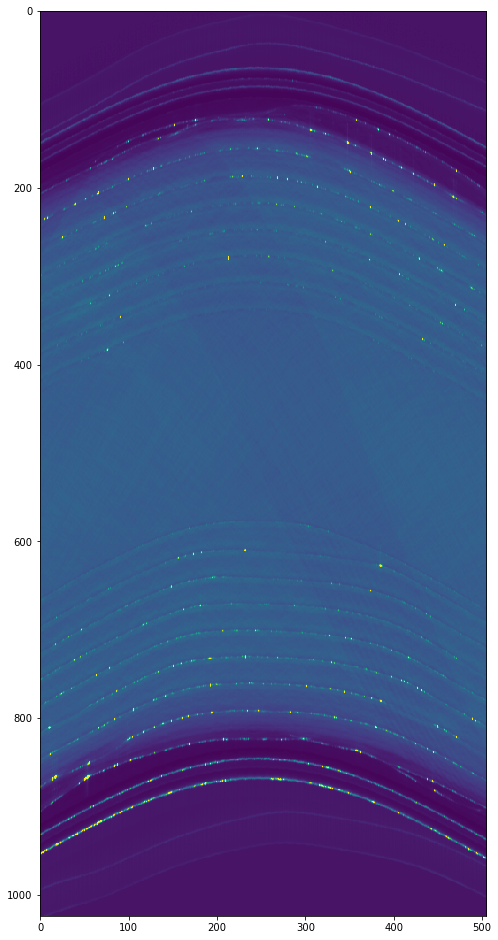

In [8]:
plt.figure(figsize = (8, 20))
plt.imshow(np.sum(slice.sinos,axis=2),
           vmin = 0, 
           vmax = 0.15,
           interpolation = None)

Pre Processing Steps:

slice.sinonorm: Set to 1 if you want to normalise

slice.ofs: Set number of "empty" Air scans at the bottom of sinogram --> Removes Air scattering e.g. 5

slics.crsr: Used to center the entire sinogram. Set number of pixels around the center to search, e.g. 100

slice.wiggle: Set to 1 of you want to run this. Processes Sinogram stripewise and centers around the center of mass. Useful in case Sinogram is "shaky". Adds noise and is slow. Only use if absolutely necessary

In [9]:
slice.sinonorm = 1
slice.ofs = 5 
slice.crsr = 200 
slice.wiggle = 0 

Runs Sino Processing (Now with Progress Bars)

In [10]:
slice.sinoproc()
slice.ProcSinos.run()

Running scalesinos


  5%|▌         | 27/505 [00:00<00:01, 262.82it/s]

scalesinos done
Running airrem


100%|██████████| 505/505 [00:01<00:00, 262.17it/s]


airrem done
Running Sinocentering


100%|██████████| 3000/3000 [00:37<00:00, 79.02it/s]

Sincocentering done
<class 'numpy.float64'>


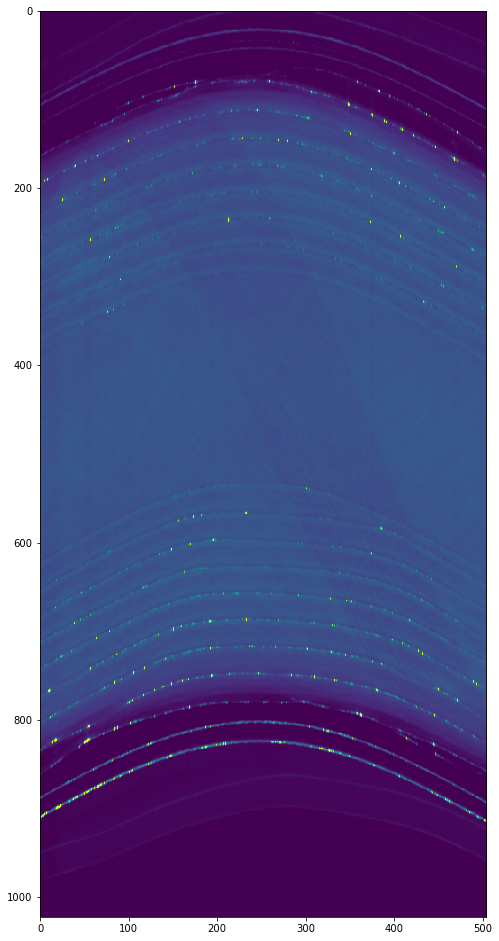

In [11]:
#Showing Corrected Sino
plt.figure(figsize = (8, 20))
plt.imshow(np.sum(slice.ProcSinos.sinos_proc,axis=2),
           vmin = 0, 
           vmax = 0.15,
           interpolation = None)

Setting Parameters for reconstruction

slice.maxTh: sets the maximum theta value (not 180 when using interlaced scan!) e.g. 181.44

Reconstruction also has a progressbar now

WAXS only:

slice.calcbackground:  Set True if you want to run an automatic background determining algorithm (based on sonneveld visser) for every XRD in the image

slice.polyorder sets the order of the polynomial used for the background e.g. 5

slice.samplesize sets the number of points between each background data point e.g. 40

Then starts the reconstruction (slow if no GPU)

In [12]:
slice.maxTh = 181.44
slice.calcbackground = False
slice.polyorder = 5
slice.samplesize = 40

slice.fbprec_vol()
slice.Rec.run()

  0%|          | 0/3000 [00:00<?, ?it/s]

The gpyfft module was not found. The Fourier transforms will be done on CPU. For more performances, it is advised to install gpyfft.
Writing Volume


  0%|          | 6/3000 [00:00<00:53, 56.36it/s]

Starting remring


100%|██████████| 3000/3000 [00:46<00:00, 65.20it/s]


Use e.g. "slice.save_XRDCT('/data/id31/inhouse/Erik', Samplename)" if you want to save the entire volume

Finally, the reconstructed slice

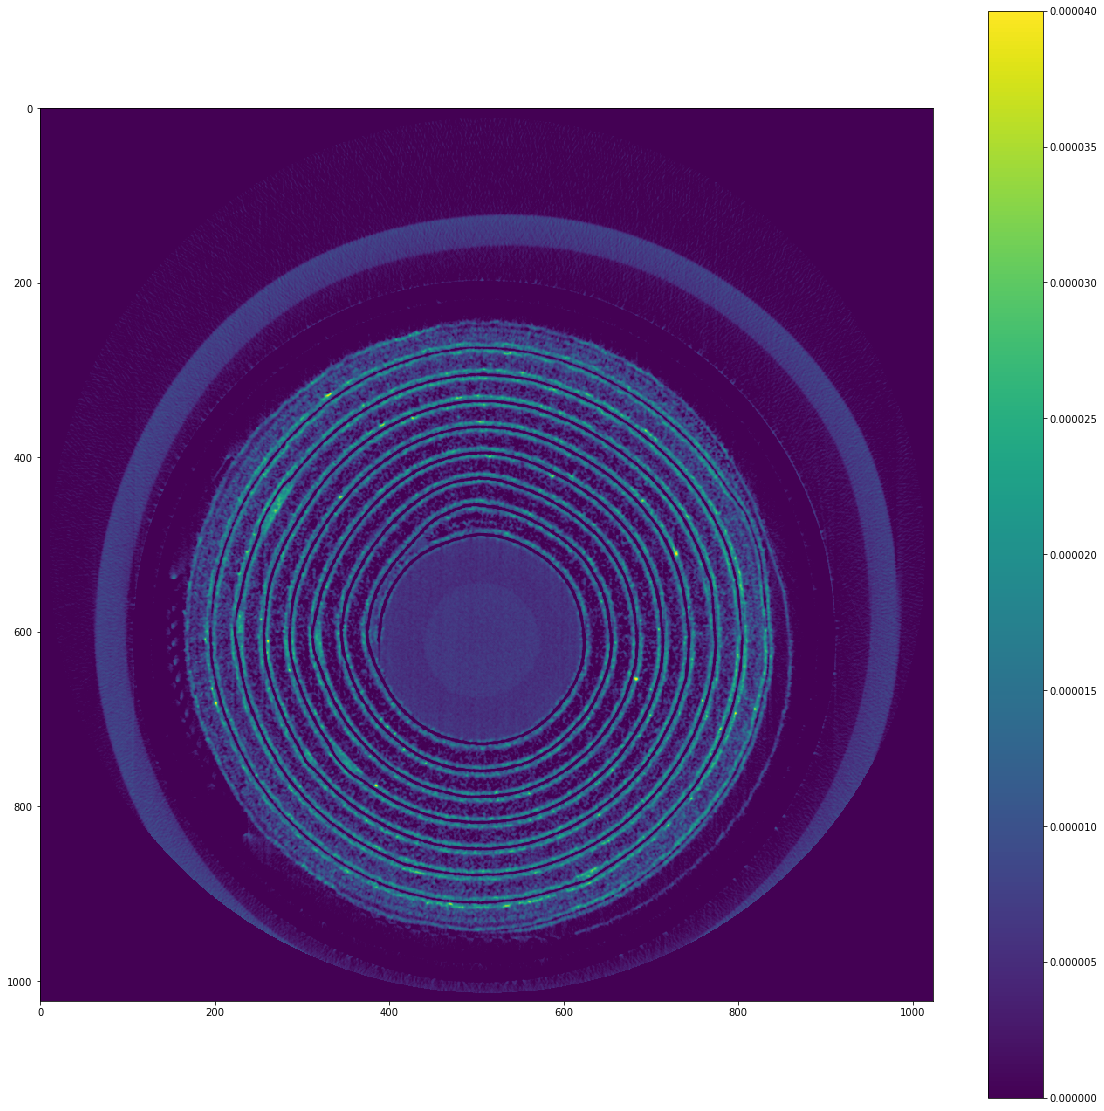

In [13]:
#Showing transmission corrected Reconstructed Slice
plt.figure(figsize = (20, 20))
plt.imshow(np.sum(slice.Rec.bp[:,:,46:269],axis=2),
           vmin = 0, 
           vmax = 0.00004,
           interpolation = None)
plt.colorbar()

To save the saw intensity data

In [14]:
Export = np.sum(slice.Rec.bp[:,:,46:269],axis=2) #set range here
fimg = fabio.tifimage.TifImage(data=Export.astype("float32"))
#fimg.save(Samplename+"_Intensity.tif")

Checking different spots in the image

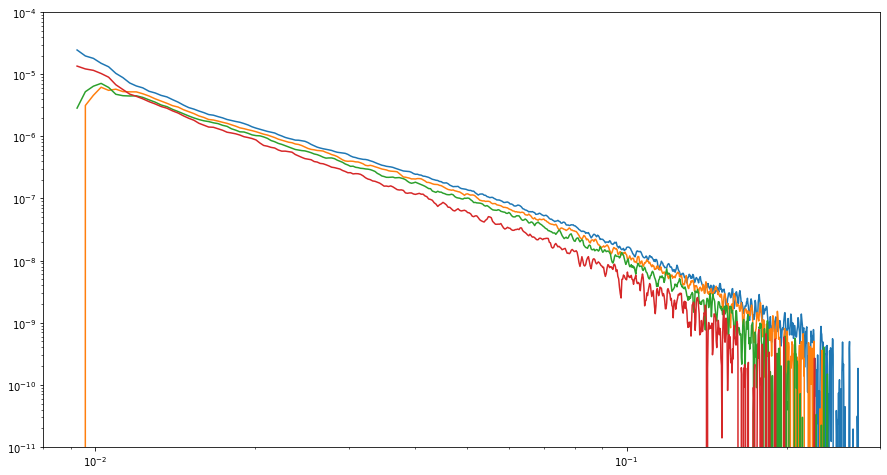

In [17]:
plt.figure(figsize = (15, 8))
plt.plot(slice.q,slice.Rec.bp[460,269]) #Spot1 very bright
plt.plot(slice.q,slice.Rec.bp[454,273]) #Spot2 bright
plt.plot(slice.q,slice.Rec.bp[466,263]) #Spot3 middle
plt.plot(slice.q,slice.Rec.bp[457,270]) #Spot5 very dark next to 1

plt.xlim(0.008,0.3)
plt.ylim(0.00000000001,0.0001)
plt.yscale("log")
plt.xscale("log")